<a href="https://colab.research.google.com/github/BuddGao/DL-Competition/blob/main/competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip "drive/MyDrive/DL_Project/Val Blind.zip" -d  "drive/MyDrive/DL_Project/"


In [5]:
## preprocess data
## create custom data class

from sklearn.model_selection import KFold
import os
import torch
import pandas as pd
from skimage import io, transform

#from monai.transforms import Compose, LoadImage, AddChannel, ScaleIntensity,RandRotate, ToTensor, RandFlip, RandZoom, Resize, RandGaussianNoise
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
import cv2
from PIL import Image
import glob

class CovidDataset(Dataset):
    """Covid CT dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.label_data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        ## you can apply custom transformation on the image for data augmentation
        self.transform = transform

    def __len__(self):
        return len(self.label_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.label_data.iloc[idx, 0])
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        
 
        p = self.label_data.iloc[idx, 1]

        subject_num = self.label_data.iloc[idx, 2]
        

        # should be only applied on image, not percentage or subject #
        if self.transform:
            image = self.transform(image)
        sample = {'image': image, 'percentage': p, 'subject': subject_num, 'img_name':img_name}
        return sample

In [6]:
class CovidTestDataset(Dataset):
    """Covid CT TEST dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_list = []
        for filename in glob.glob(self.root_dir+"/*.png"): #assuming png
          self.image_list.append(filename)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.image_list[idx]
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        image = torchvision.transforms.functional.to_tensor(image)

        # should be only applied on image, not percentage or subject #
        if self.transform:
            image = self.transform(image)
    
        sample = {'image': image, 'img_name':img_name}
        return sample

In [7]:
import torchvision
covid_dataset_train_val = CovidDataset(csv_file='drive/MyDrive/DL_Project/Train.csv',
                                    root_dir='drive/MyDrive/DL_Project/Train'
                                    ,transform = transforms.Compose([
                                                transforms.ToPILImage(),                     
                                                transforms.Resize((224, 224)),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.RandomRotation(15),
                                                
                                                transforms.ToTensor(),
                                                
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
                                    
                                    )

covid_dataset_test = CovidTestDataset(root_dir='drive/MyDrive/DL_Project/Val',
                                      transform = transforms.Compose([
                                                transforms.ToPILImage(),                     
                                                transforms.Resize((224, 224)),
                                                
                                                transforms.ToTensor(),
                                                
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
                                      #,transform = transforms.Compose([
                                        #  LoadImage(),
                                         # AddChannel(),
                                          #ScaleIntensity(),
                                          #ToTensor()])
                                    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([3, 224, 224]) 0.0 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 torch.Size([3, 224, 224]) 0.0 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 torch.Size([3, 224, 224]) 0.0 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 torch.Size([3, 224, 224]) 0.0 0


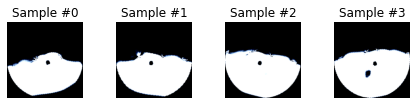

In [8]:
## plot training example
for i in range(len(covid_dataset_train_val)):
    sample = covid_dataset_train_val[i]
    print(i, sample['image'].shape, sample['percentage'], sample['subject'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'].numpy().transpose(1,2,0))
    if i == 3:
        plt.show()
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([3, 224, 224]) drive/MyDrive/DL_Project/Val/Image_0304.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 torch.Size([3, 224, 224]) drive/MyDrive/DL_Project/Val/Image_0301.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 torch.Size([3, 224, 224]) drive/MyDrive/DL_Project/Val/Image_0302.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 torch.Size([3, 224, 224]) drive/MyDrive/DL_Project/Val/Image_0303.png


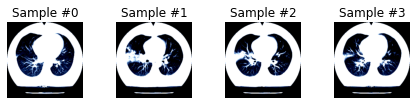

In [9]:
## plot test examples
for i in range(len(covid_dataset_test)):
    sample = covid_dataset_test[i]
    print(i, sample['image'].shape, sample['img_name'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'].numpy().transpose(1,2,0))
    if i == 3:
        plt.show()
        break

In [10]:
# generate the index of subjects for k-fold cross validation
def generate_index(dat,k):
    
    Y = list(range(0,dat[-1]['subject']+1))
    kf = KFold(n_splits=k, shuffle=True)
    n = len(Y)
    index = {'train_index':[],
             'val_index':[]}

    for train_index, val_index in kf.split(np.zeros(n), Y):
        index['train_index'].append(train_index)
        index['val_index'].append(val_index)
        
    
    return pd.DataFrame(index['train_index']).T,pd.DataFrame(index['val_index']).T

In [11]:
# get links form subjects to images
dfl = pd.read_csv('drive/MyDrive/DL_Project/Train.csv')
subtoimage = []
le = []
for sub in range(0,covid_dataset_train_val[-1]['subject']+1):
  subtoimage.append(dfl[dfl['0'] == sub].index.tolist())
  le.append(len(dfl[dfl['0'] == sub].index.tolist()))

In [12]:
# get images' index form subjects' index
def get_image_index(subindex,subtoimage):
    imageindex = []
    for sub in range(0,len(subindex)):
        imageindex.extend(subtoimage[subindex[sub]])
    return imageindex

In [10]:
!pip install pretrainedmodels

     |████████████████████████████████| 58 kB 2.7 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=64418efe5be8683c8b5beeb928b40d262a8b3677a58e2d1eff7732013678b743
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
import pretrainedmodels
#For model building
import torch
from torch import nn, optim
from torch.nn import functional as F

class CNN1(nn.Module):
    def __init__(self, pretrained=True):
        super(CNN1, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained=None)
        #self.fc1 = nn.Linear(512, 256)
        self.conv1 = nn.Conv2d(512, 128, (2,2), stride=1, padding =0)
        self.conv2 = nn.Conv2d(128, 32, (2,2), stride=1, padding =0)
        #self.pool = nn.AdaptiveAvgPool2d(output_size = (1,1))
        self.dropout = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(32, 8, (2,2), stride=1, padding =0)
        self.fc1 = nn.Linear(128, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x, x.shape[3])
        # 
        #label = self.fc1(x.reshape(bs, -1))
        #x = self.pool(x)
        #x = F.relu(self.fc1(x))

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(F.relu(x))
        #print(x.size()) # [8, 8, 4, 4]
        label = self.fc1(x.reshape(bs, -1))  # [8, 128]
        return label

ModuleNotFoundError: ignored

In [28]:
from torchsummary import summary
model_CNN = CNN1(True).to(device)

summary(model_CNN,input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [15]:
def train_model(model, criterion, optimizer, n_epochs=21):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    for epoch in range(1, n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        mse = 0
        mymse = 0
        # train the model #
        model.train()
        for batch_idx, sample_batched in enumerate(train_dataloader):
            # importing data and moving to GPU
            image, label = sample_batched['image'].to(device), sample_batched['percentage'].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            output=model(image).reshape(-1)
            # calculate loss
            loss = criterion((output).type(torch.FloatTensor).to(device), label.type(torch.FloatTensor).to(device))
            # back prop
            loss.backward()
            # grad
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        # validate the model #
        model.eval()
        
        for batch_idx, sample_batched in enumerate(val_dataloader):
            image, label = sample_batched['image'].to(device), sample_batched['percentage'].to(device)  
            output = model(image).reshape(-1)
            # calculate loss
            loss=criterion((output).type(torch.FloatTensor).to(device), label.type(torch.FloatTensor).to(device))
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), 'drive/MyDrive/DL_Project/model.pth')
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
    

    # return trained model
    return model,valid_loss_min

In [16]:
def train_val_dataloader(split_i, train_index, val_index, covid_dataset_train_val, subtoimage):
  train_imageindex = get_image_index(train_index.iloc[:,split_i],subtoimage)
  val_imageindex = get_image_index(val_index.iloc[:,split_i],subtoimage)
  train_dataset = torch.utils.data.Subset(covid_dataset_train_val,train_imageindex)
  val_dataset = torch.utils.data.Subset(covid_dataset_train_val,val_imageindex)
  train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
  val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0)
  return train_dataloader,val_dataloader

In [75]:
k = 4
train_index,val_index = generate_index(covid_dataset_train_val,k)
test_dataloader = DataLoader(covid_dataset_test, batch_size=8, shuffle=True, num_workers=0)

# Normalization prediction need inverse.
## normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
valid_cvloss = []
test_df = []
mae_dl = []
mamse = []
for split_i in range(0,k):
  ## split given train set to train & val set by subjects
  print('CV Fold - ', split_i)

  train_dataloader,val_dataloader = train_val_dataloader(split_i, train_index, val_index, covid_dataset_train_val, subtoimage)
  #Setting model and moving to device
  model_CNN = CNN1(True).to(device)

  # Freeze training for all "features" layers
  for param in model_CNN.parameters():
      param.requires_grad = False

  model_CNN.conv1 = nn.Conv2d(512, 128, (2,2), stride=1, padding =0)
  model_CNN.conv2 = nn.Conv2d(128, 32, (2,2), stride=1, padding =0)
  model_CNN.conv3 = nn.Conv2d(32, 8, (2,2), stride=1, padding =0)
  model_CNN.fc1 = nn.Linear(128, 1)

  if torch.cuda.is_available():
      model_CNN = model_CNN.cuda()
  criterion = nn.SmoothL1Loss()
  #optimizer = optim.SGD(model_CNN.parameters(), lr=0.001, momentum=0.9)
  model_CNN_grad_paramaters = filter(lambda p: p.requires_grad, model_CNN.parameters())
  optimizer = optim.Adam(model_CNN_grad_paramaters, lr=0.0005)

  ## training model
  model_conv,valid_loss_min=train_model(model_CNN, criterion, optimizer)

  valid_cvloss.append(valid_loss_min)
  ## load best val_model 
  model_conv = CNN1(True).to(device)
  model_conv.load_state_dict(torch.load('drive/MyDrive/DL_Project/model.pth'))
  model_conv.eval()
  ## val_mse
  #mae_loss = 0
  #mae = 0
  #for batch_idx, sample_batched in enumerate(val_dataloader):
   #         image, label = sample_batched['image'].to(device), sample_batched['percentage'].to(device)  
    #        output = model_conv(image).reshape(-1)
     #       
      #      loss=nn.L1Loss(((output).type(torch.FloatTensor).to(device), label.type(torch.FloatTensor).to(device)))
       #     mse_loss = mse_loss + ((1 / (batch_idx + 1)) * (loss.data - mse_loss))
        #    mse += loss.data
  #mse_dl.append(mae_loss)
  #mymse.append(mae)
  ## test_pred
  df = pd.DataFrame(columns=['image_name','output'])
  for batch_idx, sample_batched in enumerate(test_dataloader):
     image= sample_batched['image'].to(device)
     img_name= sample_batched['img_name']
     output = model_conv(image).type(torch.LongTensor).reshape(-1)
     img_name = np.array(img_name).reshape(output.shape[0],1)
     o = output.cpu().data.numpy().reshape(output.shape[0],1)
     a = np.concatenate((img_name,o),axis=1)
     df = df.append(pd.DataFrame(a, columns=df.columns), ignore_index=True)
  df.to_csv('drive/MyDrive/DL_Project/' + str(split_i) + '4fcv.csv', index=False, header=False)  
  test_df.append(df)


Epoch 1, Batch 1 loss: 21.230022
Epoch 1, Batch 101 loss: 15.079804
Epoch 1, Batch 201 loss: 12.560377
Epoch: 1 	Training Loss: 11.534252 	Validation Loss: 11.420654
Validation loss decreased (inf --> 11.420654).  Saving model ...
Epoch 2, Batch 1 loss: 7.148390
Epoch 2, Batch 101 loss: 9.740016
Epoch 2, Batch 201 loss: 9.398560
Epoch: 2 	Training Loss: 9.128562 	Validation Loss: 9.414207
Validation loss decreased (11.420654 --> 9.414207).  Saving model ...
Epoch 3, Batch 1 loss: 5.181296
Epoch 3, Batch 101 loss: 8.545670
Epoch 3, Batch 201 loss: 8.596227
Epoch: 3 	Training Loss: 8.627314 	Validation Loss: 10.125955
Epoch 4, Batch 1 loss: 10.535910
Epoch 4, Batch 101 loss: 7.759298
Epoch 4, Batch 201 loss: 7.977429
Epoch: 4 	Training Loss: 8.101211 	Validation Loss: 9.789248
Epoch 5, Batch 1 loss: 9.341356
Epoch 5, Batch 101 loss: 8.488050
Epoch 5, Batch 201 loss: 8.149611
Epoch: 5 	Training Loss: 7.985822 	Validation Loss: 10.368964
Epoch 6, Batch 1 loss: 1.725059
Epoch 6, Batch 101 l

In [31]:
# test_df = []
# for split_i in range(4):
#   file = pd.read_csv('drive/MyDrive/DL_Project/' + str(split_i) + '4fcv.csv', header=None).sort_values(0)
#   test_df.append(file)
# test_df[1]

# res = test_df[0][[0]]
# res[0] = res[0].str.split("/").str[-1]
# for idx in range(len(test_df)):
#   test_df[idx] = test_df[idx].sort_values(0,ignore_index=True)
# all = pd.concat(test_df,axis=1)
# # all.to_csv('drive/MyDrive/DL_Project/raw_predictions.csv', index=False, header=False)
# all = all.drop(columns=0).astype(float)
# res['output'] = all.mean(axis=1)
# res.to_csv('drive/MyDrive/DL_Project/predictions.csv', index=False, header=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [1]:
res = test_df[0][['image_name']]
res['image_name'] = res['image_name'].str.split("/").str[-1]
for idx in range(len(test_df)):
  test_df[idx] = test_df[idx].sort_values('image_name',ignore_index=True)
all = pd.concat(test_df,axis=1)
# all.to_csv('drive/MyDrive/DL_Project/raw_predictions.csv', index=False, header=False)
all = all.drop(columns='image_name').astype(float)
res['output'] = all.mean(axis=1)
res.to_csv('drive/MyDrive/DL_Project/predictions.csv', index=False, header=False)


NameError: ignored

下面不知道干啥用的

In [46]:
test_dataloader = DataLoader(covid_dataset_test, batch_size=8, shuffle=True, num_workers=0)

df = pd.DataFrame(columns=['image_name','output'])

for batch_idx, sample_batched in enumerate(test_dataloader):
    image= sample_batched['image'].to(device)
    img_name= sample_batched['img_name']
    output = model_conv(image).type(torch.LongTensor).reshape(-1)
    img_name = np.array(img_name).reshape(output.shape[0],1)
    o = output.cpu().data.numpy().reshape(output.shape[0],1)
    
    a = np.concatenate((img_name,o),axis=1)
   
    df = df.append(pd.DataFrame(a, columns=df.columns), ignore_index=True)
    

In [ ]:
df['output'] = df['output'].astype(float)
df['output'].value_counts()
df3 = pd.merge(df1,df,how='inner',on='image_name')

In [ ]:
test_df[0]

,image_name,output
0,drive/MyDrive/DL_Project/Val/Image_0986.png,4
1,drive/MyDrive/DL_Project/Val/Image_1157.png,4
2,drive/MyDrive/DL_Project/Val/Image_0468.png,4
3,drive/MyDrive/DL_Project/Val/Image_0379.png,4
4,drive/MyDrive/DL_Project/Val/Image_0239.png,4
...,...,...
1296,drive/MyDrive/DL_Project/Val/Image_0574.png,4
1297,drive/MyDrive/DL_Project/Val/Image_0856.png,4
1298,drive/MyDrive/DL_Project/Val/Image_0571.png,4
1299,drive/MyDrive/DL_Project/Val/Image_0011.png,4


In [ ]:
#Extracting image name from the image path
test_df[0]['image_name']=test_df[0]['image_name'].str.split("/").str[-1]

In [ ]:
test_df[0].to_csv('drive/MyDrive/DL_Project/predictions.csv', index=False, header=False)

In [ ]:
test_df[0].head()

,image_name,output
0,Image_0986.png,4
1,Image_1157.png,4
2,Image_0468.png,4
3,Image_0379.png,4
4,Image_0239.png,4


In [ ]:
test_df[0]=df

In [ ]:
test_df[0]['output'] = test_df[0]['output']*test_df[0]['output']

TypeError: ignored

In [ ]:
test_df[0]

IndexError: ignored